In [30]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns
from matplotlib.pylab import rcParams

Load signal and background trees

In [2]:
signalFile=TFile.Open("samples/sig_nonres_bbtt.root")
backgroundFile=TFile.Open("samples/sig_nonres_bbww.root")

In [3]:
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")

In [4]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  217248
background events number before cut is:  84531


Convert minitree into numpy

In [5]:
signalArray=signalTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
backgroundArray=backgroundTree.AsMatrix(["weight","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
print(signalArray.shape)

(217248, 22)


In [6]:
dataSignal=pd.DataFrame(data=signalArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

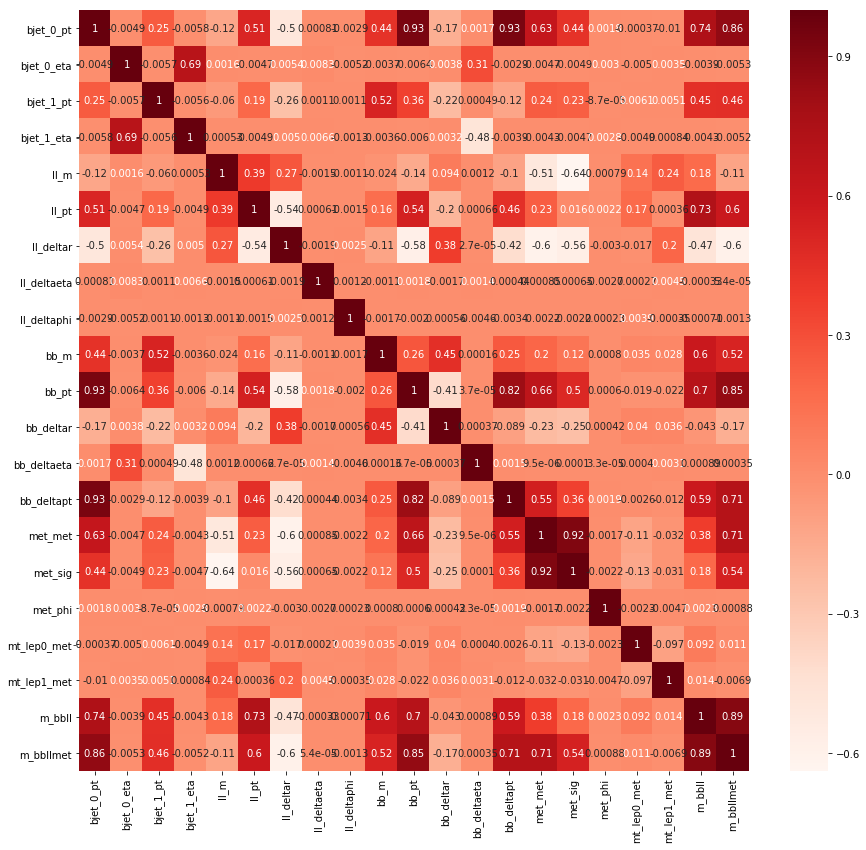

In [7]:
plt.figure(figsize=(15,14))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

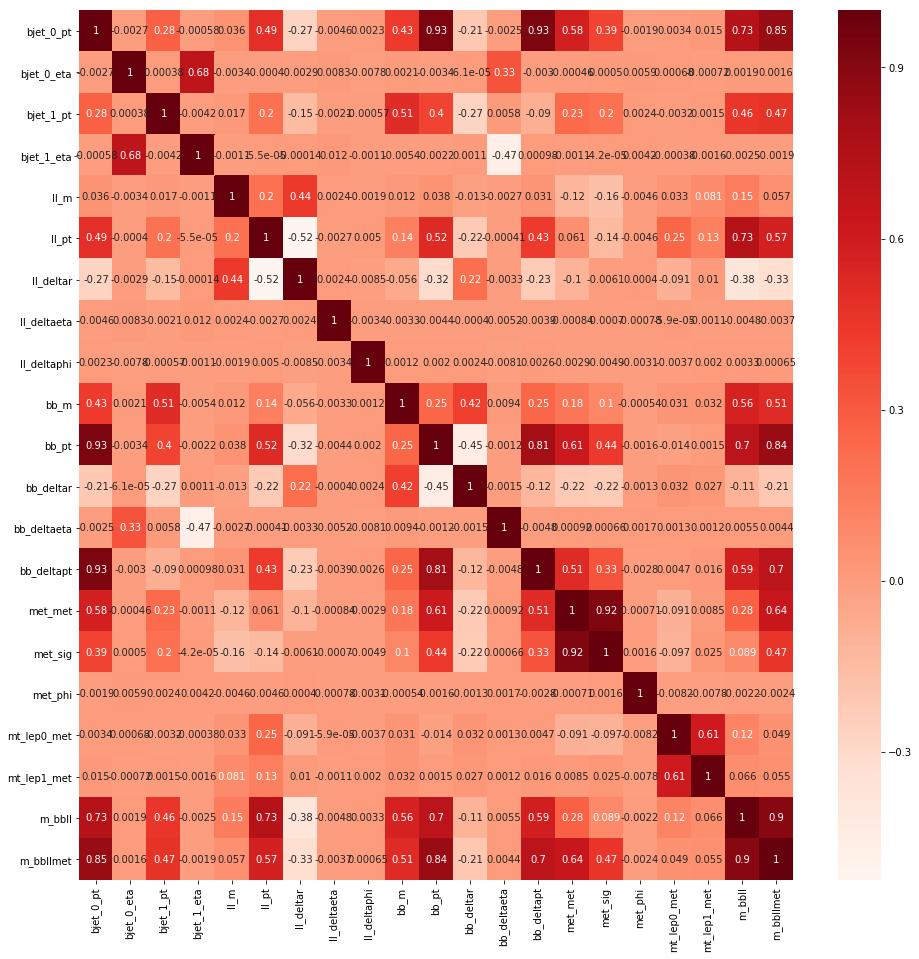

In [8]:
dataBackground=pd.DataFrame(data=backgroundArray[:,1:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(16,16))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()



In [9]:
print(signalArray)

[[ 5.99125689e-08  3.43779406e+05 -8.89795244e-01 ...  8.16832910e+03
   1.01459575e+06  1.15864900e+06]
 [ 1.37623146e-05  2.02115812e+05 -1.13858283e+00 ...  4.82755898e+04
   4.13342219e+05  5.49812625e+05]
 [ 1.21445784e-06  2.04746391e+05  1.65332592e+00 ...  2.39445947e+03
   4.90221562e+05  9.90220812e+05]
 ...
 [ 3.69084698e-05  9.59073438e+04 -1.60544014e+00 ...  1.28037285e+04
   2.70796531e+05  3.64658312e+05]
 [ 4.55069750e-06  2.05500875e+05  5.38439453e-01 ...  1.36688916e+04
   5.46038250e+05  6.63057375e+05]
 [ 1.65528623e-06  2.39564734e+05 -1.39261913e+00 ...  3.73748608e+03
   4.83871188e+05  1.09625988e+06]]


In [10]:
print(signalArray[:,1])

[343779.40625  202115.8125   204746.390625 ...  95907.34375  205500.875
 239564.734375]


Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [11]:
signalSample=signalArray#[(abs(signalArray[:,3])>2.0)&(signalArray[:,1]>300)]
backgroundSample=backgroundArray#[(abs(backgroundArray[:,3])>2.0)&(backgroundArray[:,1]>300)]

In [12]:
print(len(signalSample))
print(len(backgroundSample))

217248
84531


In [13]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)

signal event number after cut is:  217248
background event number after cut is: 84531


Split datasets into training and testing subsets

In [14]:
trainingRatio=0.9
sigTrainNum=int(signalNum*0.9)
backgroundTrainNum=int(backgroundNum*0.9)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


training signal events number is:  195523
testing signal events number is:  21725
training background events number is:  76077
testing background events number is:  8454


In [15]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)

[[ 0.00000000e+00  2.54292281e-04  8.37039219e+04 ...  9.73175625e+04
   2.72347344e+05  4.23144844e+05]
 [ 0.00000000e+00  1.29087278e-05  2.08606938e+05 ...  3.41941602e+04
   5.17863094e+05  7.85121688e+05]
 [ 0.00000000e+00  5.05419498e-05  1.25474977e+05 ...  7.27420078e+04
   3.62830094e+05  4.77336000e+05]
 ...
 [ 0.00000000e+00  2.36303608e-05  3.29779625e+05 ...  3.00552783e+03
   5.86084750e+05  6.86617062e+05]
 [ 0.00000000e+00 -4.06433589e-05  1.93701078e+05 ...  2.17897695e+04
   2.71294000e+05  4.44571000e+05]
 [ 0.00000000e+00  6.86499316e-06  1.76849109e+05 ...  5.30523867e+04
   4.77484812e+05  8.07346125e+05]]
0.34112102468487104


In [16]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,2:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,2:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

<tf.Tensor 'Cast_1:0' shape=(271600, 21) dtype=float32>

Signal and background training sets should have same yield in training

(271600,)
(271600,)


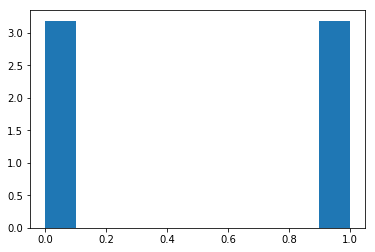

In [17]:
plt.hist(dataTrain[:,0],weights=dataTrainWeight)
print(dataTrainWeight.shape)
dataTrainWeight=dataTrainWeight.transpose()
print(dataTrainWeight.shape)
classweight = {0: 19.75,
                1: 1.}

Build model

In [ ]:
model = Sequential()
model.add(Dense(300, kernel_initializer="random_normal", activation="relu",
    input_dim=21))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="random_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["binary_accuracy"])

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

In [ ]:
model.save('model_HHZZ.h5')
model.summary()

In [ ]:
model.fit(dataTrainSample,dataTrainLabel,batch_size=50, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

In [ ]:
signalNN=model.predict(signalSample[:,1:])
backgroundNN=model.predict(backgroundSample[:,1:])
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample)

In [ ]:
backgroundNN=model.predict(backgroundSample[:,1:])
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [ ]:
model.save('model_4lNN.h5')
model.summary()

In [ ]:
signalNNScore=model.predict(signalArray[:,1:])
backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

In [ ]:
plt.hist(signalNNScore,bins=20)

In [ ]:
cuda.select_device(0)
cuda.close()

In [18]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalArray[:,1:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundArray[:,1:],feature_names=varName)
param = {'max_depth': 5, 'eta': 0.6, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_exact'
param['grow_policy'] = 'depthwise'
param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]

/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
/home/shuzhou/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndar

In [19]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist)

[0]	eval-auc:0.744598	train-auc:0.741083
[1]	eval-auc:0.768926	train-auc:0.765267
[2]	eval-auc:0.769759	train-auc:0.766236
[3]	eval-auc:0.791527	train-auc:0.789884
[4]	eval-auc:0.794611	train-auc:0.793097
[5]	eval-auc:0.795734	train-auc:0.796135
[6]	eval-auc:0.796935	train-auc:0.798422
[7]	eval-auc:0.813186	train-auc:0.814022
[8]	eval-auc:0.814789	train-auc:0.815494
[9]	eval-auc:0.814434	train-auc:0.815831
[10]	eval-auc:0.814958	train-auc:0.81669
[11]	eval-auc:0.819696	train-auc:0.820938
[12]	eval-auc:0.820487	train-auc:0.822132
[13]	eval-auc:0.82847	train-auc:0.830535
[14]	eval-auc:0.830273	train-auc:0.832319
[15]	eval-auc:0.835696	train-auc:0.83785
[16]	eval-auc:0.835875	train-auc:0.837959
[17]	eval-auc:0.836972	train-auc:0.839256
[18]	eval-auc:0.839483	train-auc:0.841479
[19]	eval-auc:0.842456	train-auc:0.843965
[20]	eval-auc:0.842768	train-auc:0.844633
[21]	eval-auc:0.842846	train-auc:0.844766
[22]	eval-auc:0.84455	train-auc:0.846753
[23]	eval-auc:0.846105	train-auc:0.848645
[24]	e

[195]	eval-auc:0.882627	train-auc:0.885741
[196]	eval-auc:0.882594	train-auc:0.885712
[197]	eval-auc:0.88263	train-auc:0.885753
[198]	eval-auc:0.882603	train-auc:0.885733
[199]	eval-auc:0.882671	train-auc:0.885793
[200]	eval-auc:0.882668	train-auc:0.885784
[201]	eval-auc:0.882732	train-auc:0.885838
[202]	eval-auc:0.882717	train-auc:0.885826
[203]	eval-auc:0.882746	train-auc:0.885838
[204]	eval-auc:0.882725	train-auc:0.885822
[205]	eval-auc:0.88279	train-auc:0.88589
[206]	eval-auc:0.88276	train-auc:0.885877
[207]	eval-auc:0.882812	train-auc:0.885937
[208]	eval-auc:0.882829	train-auc:0.88597
[209]	eval-auc:0.882824	train-auc:0.885973
[210]	eval-auc:0.882805	train-auc:0.885953
[211]	eval-auc:0.88287	train-auc:0.886012
[212]	eval-auc:0.882846	train-auc:0.885997
[213]	eval-auc:0.882877	train-auc:0.886022
[214]	eval-auc:0.882862	train-auc:0.88601
[215]	eval-auc:0.882854	train-auc:0.886013
[216]	eval-auc:0.882875	train-auc:0.886053
[217]	eval-auc:0.882922	train-auc:0.886103
[218]	eval-auc:0.8

[387]	eval-auc:0.884189	train-auc:0.887507
[388]	eval-auc:0.88419	train-auc:0.887508
[389]	eval-auc:0.884184	train-auc:0.887509
[390]	eval-auc:0.884199	train-auc:0.887521
[391]	eval-auc:0.884191	train-auc:0.887519
[392]	eval-auc:0.8842	train-auc:0.887532
[393]	eval-auc:0.884197	train-auc:0.887532
[394]	eval-auc:0.884198	train-auc:0.887535
[395]	eval-auc:0.884191	train-auc:0.88753
[396]	eval-auc:0.884201	train-auc:0.887539
[397]	eval-auc:0.884196	train-auc:0.887539
[398]	eval-auc:0.884206	train-auc:0.88755
[399]	eval-auc:0.884202	train-auc:0.887549
[400]	eval-auc:0.884216	train-auc:0.88756
[401]	eval-auc:0.884215	train-auc:0.887561
[402]	eval-auc:0.884218	train-auc:0.887563
[403]	eval-auc:0.884216	train-auc:0.887562
[404]	eval-auc:0.884229	train-auc:0.887573
[405]	eval-auc:0.884222	train-auc:0.887573
[406]	eval-auc:0.884228	train-auc:0.887581
[407]	eval-auc:0.884225	train-auc:0.887582
[408]	eval-auc:0.884238	train-auc:0.887593
[409]	eval-auc:0.884235	train-auc:0.887591
[410]	eval-auc:0.

[579]	eval-auc:0.884672	train-auc:0.888059
[580]	eval-auc:0.884678	train-auc:0.888065
[581]	eval-auc:0.884674	train-auc:0.888063
[582]	eval-auc:0.88468	train-auc:0.888068
[583]	eval-auc:0.884676	train-auc:0.888065
[584]	eval-auc:0.884683	train-auc:0.888069
[585]	eval-auc:0.884682	train-auc:0.88807
[586]	eval-auc:0.884687	train-auc:0.888076
[587]	eval-auc:0.884686	train-auc:0.888075
[588]	eval-auc:0.884691	train-auc:0.888079
[589]	eval-auc:0.88469	train-auc:0.888081
[590]	eval-auc:0.884696	train-auc:0.888087
[591]	eval-auc:0.884691	train-auc:0.888084
[592]	eval-auc:0.884697	train-auc:0.888088
[593]	eval-auc:0.884694	train-auc:0.888087
[594]	eval-auc:0.884699	train-auc:0.88809
[595]	eval-auc:0.884699	train-auc:0.88809
[596]	eval-auc:0.884705	train-auc:0.888096
[597]	eval-auc:0.884705	train-auc:0.8881
[598]	eval-auc:0.884708	train-auc:0.888103
[599]	eval-auc:0.884707	train-auc:0.888106
[600]	eval-auc:0.88471	train-auc:0.88811
[601]	eval-auc:0.884709	train-auc:0.888109
[602]	eval-auc:0.884

[771]	eval-auc:0.884779	train-auc:0.888411
[772]	eval-auc:0.884781	train-auc:0.888413
[773]	eval-auc:0.884774	train-auc:0.888414
[774]	eval-auc:0.884778	train-auc:0.888416
[775]	eval-auc:0.884775	train-auc:0.888418
[776]	eval-auc:0.884778	train-auc:0.88842
[777]	eval-auc:0.884784	train-auc:0.888424
[778]	eval-auc:0.884785	train-auc:0.888426
[779]	eval-auc:0.884785	train-auc:0.888426
[780]	eval-auc:0.884788	train-auc:0.888429
[781]	eval-auc:0.884788	train-auc:0.888431
[782]	eval-auc:0.88479	train-auc:0.888434
[783]	eval-auc:0.884783	train-auc:0.888435
[784]	eval-auc:0.884787	train-auc:0.888437
[785]	eval-auc:0.884786	train-auc:0.888436
[786]	eval-auc:0.884788	train-auc:0.888439
[787]	eval-auc:0.884788	train-auc:0.88844
[788]	eval-auc:0.88479	train-auc:0.888443
[789]	eval-auc:0.884789	train-auc:0.888442
[790]	eval-auc:0.884791	train-auc:0.888445
[791]	eval-auc:0.88479	train-auc:0.888444
[792]	eval-auc:0.884792	train-auc:0.888447
[793]	eval-auc:0.884788	train-auc:0.888447
[794]	eval-auc:0

[963]	eval-auc:0.884919	train-auc:0.888657
[964]	eval-auc:0.884924	train-auc:0.888658
[965]	eval-auc:0.884919	train-auc:0.888658
[966]	eval-auc:0.884921	train-auc:0.88866
[967]	eval-auc:0.88492	train-auc:0.888661
[968]	eval-auc:0.884926	train-auc:0.888661
[969]	eval-auc:0.884922	train-auc:0.888662
[970]	eval-auc:0.884925	train-auc:0.888663
[971]	eval-auc:0.884924	train-auc:0.888663
[972]	eval-auc:0.884926	train-auc:0.888664
[973]	eval-auc:0.884925	train-auc:0.888664
[974]	eval-auc:0.884931	train-auc:0.888664
[975]	eval-auc:0.884927	train-auc:0.888665
[976]	eval-auc:0.884929	train-auc:0.888668
[977]	eval-auc:0.884928	train-auc:0.888667
[978]	eval-auc:0.88493	train-auc:0.888668
[979]	eval-auc:0.88493	train-auc:0.888669
[980]	eval-auc:0.884935	train-auc:0.888668
[981]	eval-auc:0.884934	train-auc:0.888667
[982]	eval-auc:0.884936	train-auc:0.888669
[983]	eval-auc:0.884931	train-auc:0.888669
[984]	eval-auc:0.884934	train-auc:0.888671
[985]	eval-auc:0.884946	train-auc:0.888674
[986]	eval-auc:

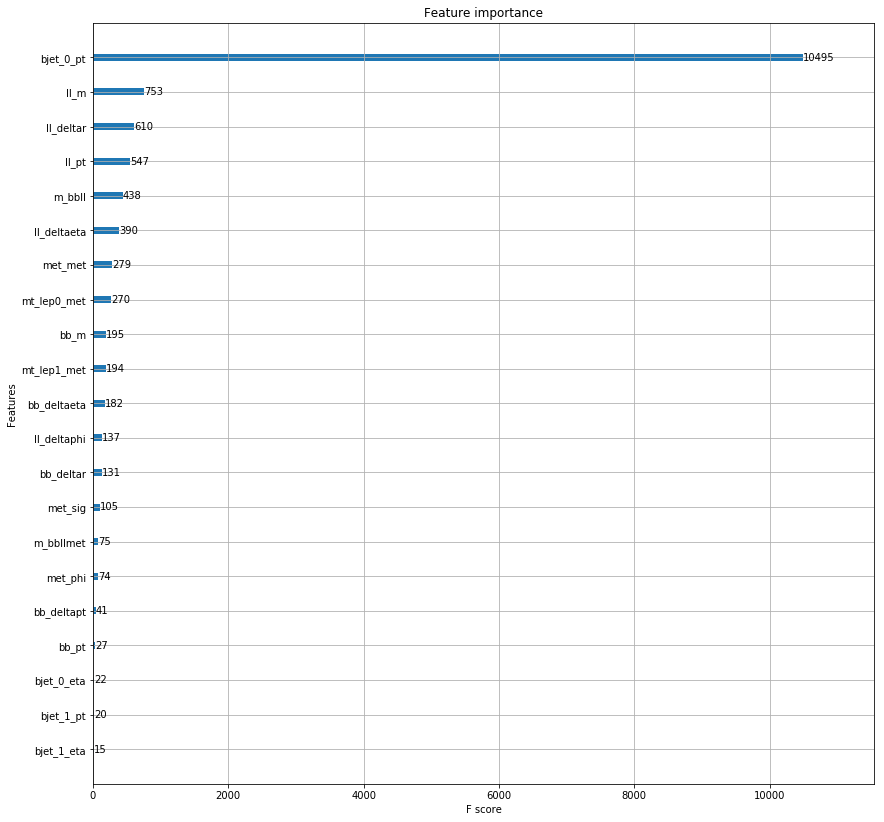

In [20]:
fig, ax = plt.subplots(figsize=(14, 14))
xgb.plot_importance(GBDT,ax=ax)

(array([26556.,  8589.,  5299.,  4127.,  3336.,  2876.,  2716.,  2673.,
         2698.,  2592.,  2794.,  2909.,  2899.,  2721.,  2367.,  2122.,
         2079.,  1939.,  2098.,  1141.]),
 array([0.00215401, 0.05174132, 0.10132864, 0.15091595, 0.20050326,
        0.25009057, 0.2996779 , 0.34926522, 0.39885253, 0.44843984,
        0.49802715, 0.54761446, 0.59720176, 0.6467891 , 0.6963764 ,
        0.74596375, 0.79555106, 0.8451384 , 0.8947257 , 0.944313  ,
        0.9939003 ], dtype=float32),
 <a list of 20 Patch objects>)

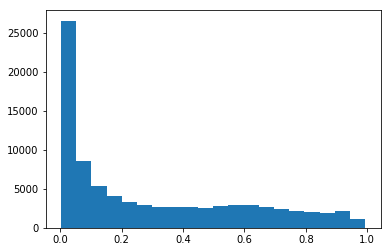

In [21]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20)

(array([  237.,   547.,   812.,  1393.,  2516.,  3950.,  5328.,  6887.,
         8160.,  9854., 14026., 19291., 21642., 22475., 22041., 20426.,
        17667., 15169., 13894., 10933.]),
 array([0.00756022, 0.05696966, 0.1063791 , 0.15578854, 0.20519798,
        0.2546074 , 0.30401686, 0.3534263 , 0.40283573, 0.45224518,
        0.5016546 , 0.5510641 , 0.60047346, 0.6498829 , 0.69929236,
        0.7487018 , 0.79811126, 0.8475207 , 0.8969301 , 0.94633955,
        0.995749  ], dtype=float32),
 <a list of 20 Patch objects>)

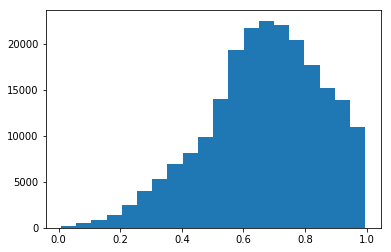

In [22]:
plt.hist(SignalScore,bins=20)

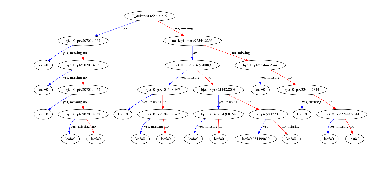

In [23]:
plot_tree(GBDT, num_trees=4)

(array([24178.,  8164.,  5494.,  4896.,  5180.,  6064.,  7177.,  8476.,
         9718., 11178., 14905., 20040., 22077., 22791., 22144., 20342.,
        17907., 15548., 14431., 10890.]),
 array([0.00215401, 0.05183376, 0.1015135 , 0.15119326, 0.200873  ,
        0.25055274, 0.3002325 , 0.34991226, 0.399592  , 0.44927177,
        0.4989515 , 0.54863125, 0.598311  , 0.64799076, 0.6976705 ,
        0.7473503 , 0.79703   , 0.8467097 , 0.8963895 , 0.94606924,
        0.995749  ], dtype=float32),
 <a list of 20 Patch objects>)

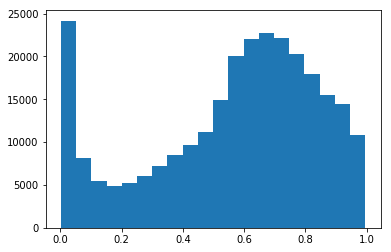

In [24]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)
plt.hist(trainScore,bins=20)

In [25]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

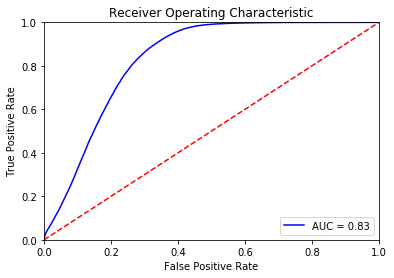

In [26]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
pickle.dump(GBDT, open("GBDT_HHttWW.pickle.dat", "wb"))

In [27]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

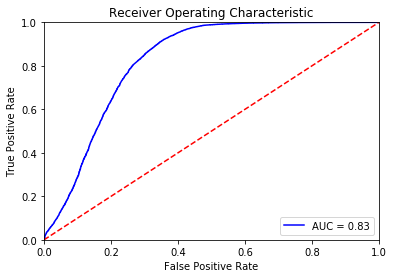

In [28]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

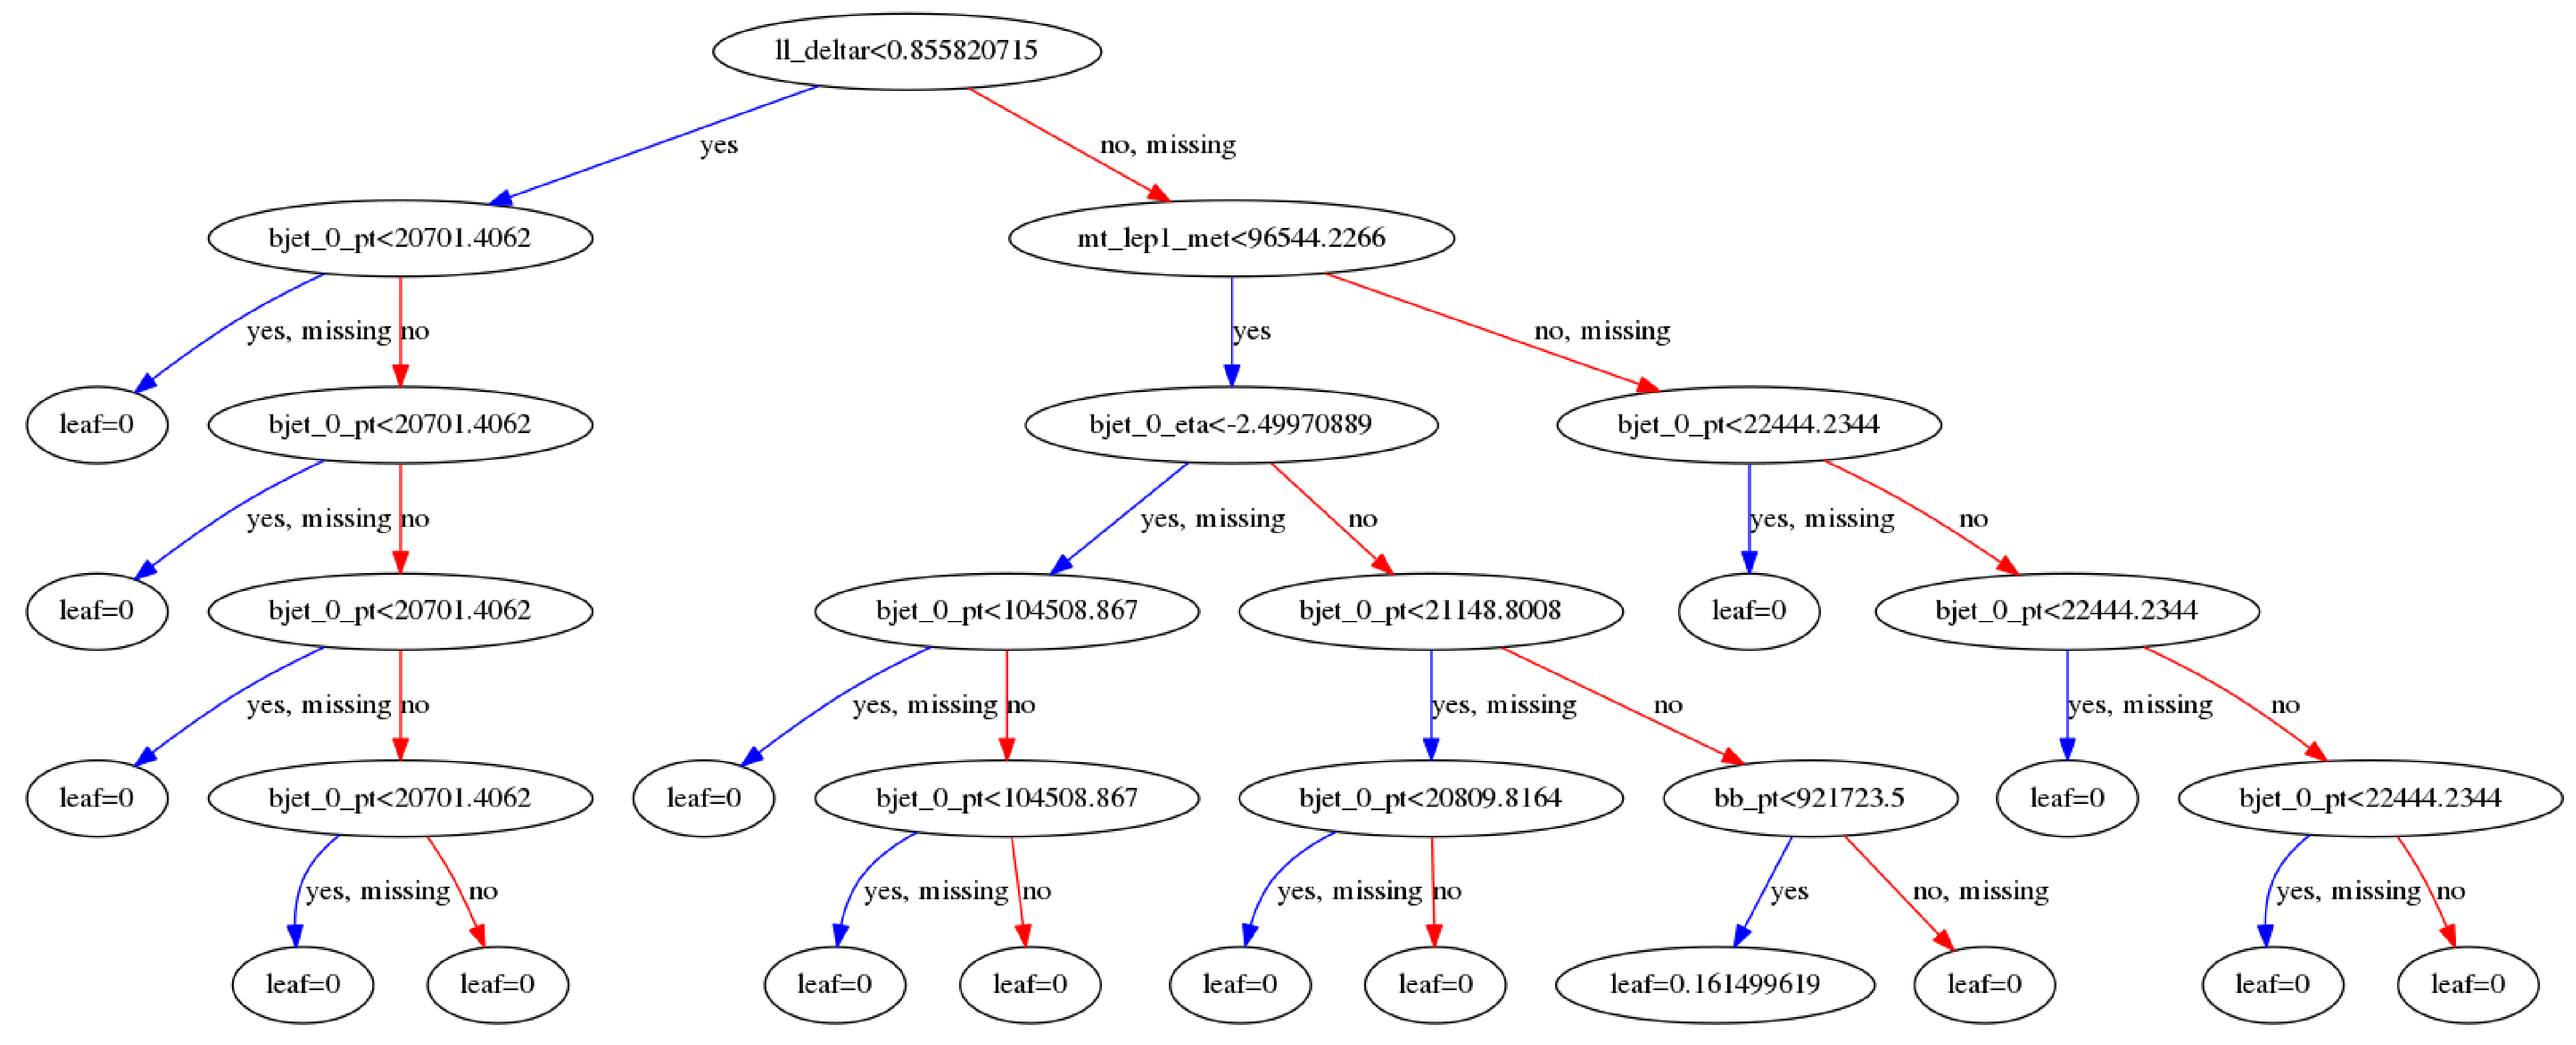

In [31]:
rcParams['figure.figsize'] = 80,50
plot_tree(GBDT, num_trees=4)